In [ ]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [2]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [3]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus Class"].to_list())

In [4]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [5]:
# Import the preprocessing module
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [89]:
# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# Bottleneck size
n_bottleneck = 5

def create_model():
    
    # Input layer
    input_layer = keras.Input(shape=(n_inputs, 1))
    
    # --------------------
    # Encoder (Trial 14 params)
    # --------------------
    hidden_layer = keras.layers.Conv1D(
        filters=32,              # 1_filter
        kernel_size=6,           # 1_kernal
        activation="relu",
        padding="same"
    )(input_layer)

    hidden_layer = keras.layers.Conv1D(
        filters=128,             # 2_filter
        kernel_size=4,           # 2_kernal
        activation="relu",
        padding="same"
    )(hidden_layer)
    
    # Bottleneck
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck, name="bottleneck")(bottleneck_lay)

    # --------------------
    # Decoder (mirror)
    # --------------------
    reset_lay = keras.layers.Dense(49 * 128)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 128))(reset_lay)

    hidden_layer = keras.layers.Conv1DTranspose(
        filters=128,
        kernel_size=4,
        activation="relu",
        padding="same"
    )(reshape_lay)

    hidden_layer = keras.layers.Conv1DTranspose(
        filters=32,
        kernel_size=6,
        activation="relu",
        padding="same"
    )(hidden_layer)

    # Output layer
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Models
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)

    return model, encoder_model


# Build models
model, encoder_model = create_model()

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="mse"
)

# Summary
model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 49, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 49, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 5)              │        31,365 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6272)           │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_10             │ (None, 49, 128)        │        65,664 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_11             │ (None, 49, 32)         │        24,608 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 49, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,038 (687.65 KB)

 Trainable params: 176,038 (687.65 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Train the model
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.25,
                    callbacks=[es_callback])

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.4541 - val_loss: 0.1433
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0607 - val_loss: 0.0375
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0301 - val_loss: 0.0315
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0271 - val_loss: 0.0322
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0316 - val_loss: 0.0316
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0250 - val_loss: 0.0266
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0220 - val_loss: 0.0229
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0182 - val_loss: 0.0194
Epoch 9/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0161 - val_loss: 0.0186
Epoch 10/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0145 - val_loss: 0.0162
Epoch 11/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0133 - val_loss: 0.0153
Epoch 12/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step

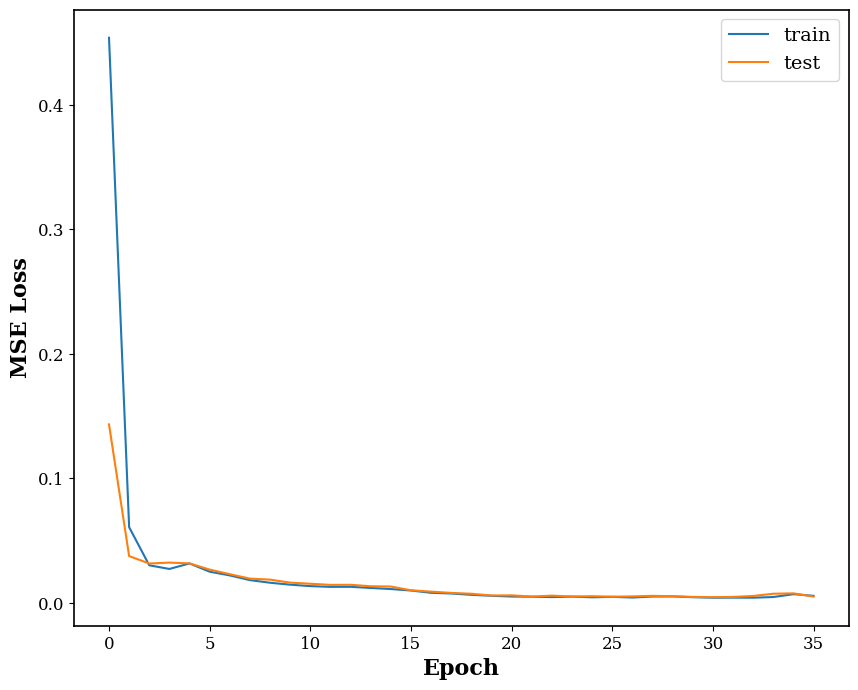

In [91]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


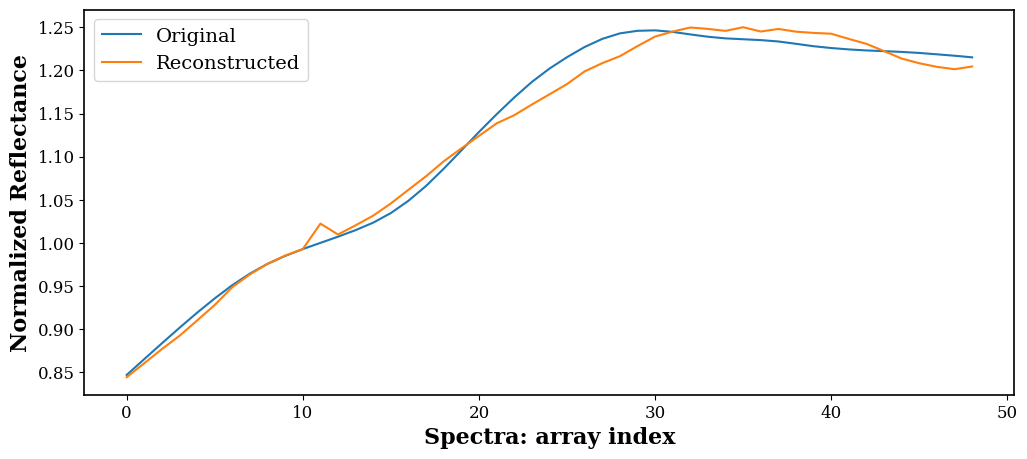

In [92]:
# Which index shall be displayed?
index_val = 957

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

In [93]:
# Reconstruction error per sample
recon_errors = np.mean(
    (X_train_scaled - model.predict(X_train_scaled, verbose=0))**2,
    axis=1
)

# Indices
idx_best = np.argmin(recon_errors)
idx_worst = np.argmax(recon_errors)
idx_median = np.argsort(recon_errors)[len(recon_errors)//2]
idx_random = np.random.choice(len(recon_errors), 1)[0]

[idx_best, idx_median, idx_random, idx_worst]


[np.int64(167), array([0]), np.int32(988), np.int64(262)]

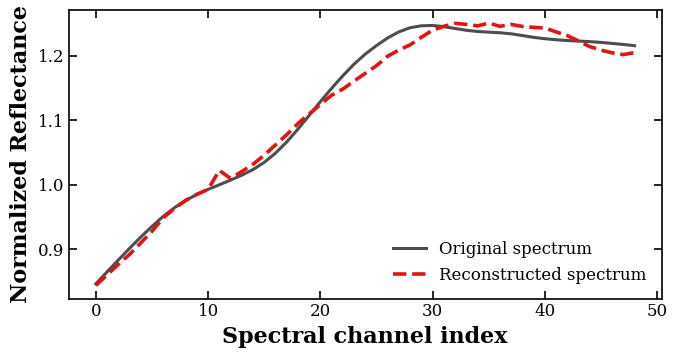

In [94]:
import matplotlib.pyplot as plt

# -----------------------------
# HARD RESET STYLE
# -----------------------------
plt.style.use("default")
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.labelweight": "bold",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.linewidth": 1.2,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
})

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(7.0, 3.8))

ax.plot(
    org_signal,
    color="0.3",
    linewidth=2.2,
    label="Original spectrum"
)

ax.plot(
    rec_signal,
    color="#e11313",
    linewidth=2.6,
    linestyle="--",
    label="Reconstructed spectrum"
)

ax.set_xlabel("Spectral channel index")
ax.set_ylabel("Normalized Reflectance")

ax.tick_params(
    direction="in",
    length=6,
    width=1.2,
    top=True,
    right=True
)

ax.grid(False)
ax.legend(frameon=False, fontsize=12)

plt.tight_layout()

plt.savefig(
    "reconstruction_white_bg.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"  # critical
)

plt.show()


In [95]:
# Create dataframe that contains the encoder values and the corresponding class to see whether the
# autoencoder values cluster in a way

# Encode the spectra
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the encoded data to fit
# the scaler
enc_scaler = preprocessing.StandardScaler().fit(X_encoded)

# Transform now the encoded data (later used for our scikit-learn method)
X_encoded_scaled = enc_scaler.transform(X_encoded)

# Merge the classes
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create a column names array for the encoded space
encoder_space = [f"enc{enc_nr+1}" for enc_nr in range(n_bottleneck)]
encoder_space_cols = encoder_space.copy()
encoder_space.extend(["Main_Group", "Bus_Class"])

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded_scaled,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=encoder_space)

# Change the dtype to float
encoded_df.loc[:, encoder_space[:-2]] = encoded_df.loc[:, encoder_space[:-2]].astype(float)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [96]:
import hdbscan
import numpy as np
import pandas as pd

# HDBSCAN model
hdb = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=10,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

# Fit HDBSCAN
hdb.fit(X_encoded_scaled)

# Assign cluster labels
encoded_df.loc[:, "HDBSCAN_Class"] = hdb.labels_

# Assign soft membership probabilities
encoded_df.loc[:, "HDBSCAN_Prob"] = hdb.probabilities_

encoded_df[["HDBSCAN_Class", "HDBSCAN_Prob"]].head()


,HDBSCAN_Class,HDBSCAN_Prob
0,-1,0.000000
1,0,0.696580
2,0,0.547071
3,-1,0.000000
4,0,1.000000


In [97]:
encoded_grouped_df = pd.crosstab(
    index=encoded_df["Main_Group"],
    columns=encoded_df["HDBSCAN_Class"]
)

encoded_grouped_df


HDBSCAN_Class,-1,0,1
Main_Group,,,
C,79,317,0
Other,138,2,17
S,171,0,378
X,61,174,2


In [98]:
encoded_main_s_df = encoded_df.loc[
    encoded_df["Main_Group"] == "S"
].copy()

encoded_main_s_df.groupby("HDBSCAN_Class").count()


,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,HDBSCAN_Prob
HDBSCAN_Class,,,,,,,,
-1,171,171,171,171,171,171,171,171
1,378,378,378,378,378,378,378,378


In [99]:
# Exclude noise cluster (-1)
cluster_counts = (
    encoded_main_s_df["HDBSCAN_Class"]
    .value_counts()
    .drop(index=-1, errors="ignore")
)

dominant_cluster = cluster_counts.idxmax()
dominant_cluster


np.int64(1)

In [100]:
encoded_main_s_confident = encoded_main_s_df.loc[
    (encoded_main_s_df["HDBSCAN_Class"] == dominant_cluster) &
    (encoded_main_s_df["HDBSCAN_Prob"] >= 0.95)
]

encoded_main_s_confident.shape


(70, 9)

In [101]:
import pingouin as pg

encoded_main_s = np.array(
    encoded_main_s_confident[encoder_space_cols].values,
    dtype="float64"
)

# Sanity check
encoded_main_s.shape


(70, 5)

In [102]:
# Henze–Zirkler multivariate normality test
pg.multivariate_normality(encoded_main_s)


HZResults(hz=np.float64(0.9660544382857255), pval=np.float64(0.06485645994348556), normal=True)

In [103]:
# show counts per cluster for S-type
print(encoded_main_s_df["HDBSCAN_Class"].value_counts(dropna=False))

# show dominant cluster and how many high-confidence members it has
print("dominant_cluster =", dominant_cluster)
print("confident shape =", encoded_main_s_confident.shape)
print("fraction confident =", len(encoded_main_s_confident)/len(encoded_main_s_df))

# multivariate normality test result
print(pg.multivariate_normality(encoded_main_s))

HDBSCAN_Class
 1    378
-1    171
Name: count, dtype: int64
dominant_cluster = 1
confident shape = (70, 9)
fraction confident = 0.12750455373406194
HZResults(hz=np.float64(0.9660544382857255), pval=np.float64(0.06485645994348556), normal=True)
